# Data-Generating Contextual Motif Example

### Introduction
This notebook serves as a walkthrough for the data-generating contextual motif tools described in https://arxiv.org/abs/1703.02144

In [223]:
import numpy as np
from sklearn.externals import joblib
import sklearn
from collections import Counter
from matplotlib import pyplot as plt
%matplotlib inline

from lib import data_generating_motifs as dgm
from lib import data_derived_motifs as ddm

## MMM and CMMM
We begin by demonstrating the baseline motif mixture model and contextual motif mixture model. Since data-generating motifs assume a generative model, we can simulate data from the respective generative models instead of randomly generating it as in the data-derived motif example.

In [146]:
num_motifs = 2 # does not include background motif
motif_length = 8
num_data = 10
num_cont = 2
mpc = 9
background_ratio = 0.5

In [149]:
# creating and sampling from motif mixture model.
# all parts of a signal are generated by a motif
# to accomodate high-variance portions of the signal we include a background motif
mmm_sim = dgm.MotifMixtureModel(num_motifs=num_motifs, w=motif_length, 
                                background_ratio=background_ratio)
mmm_data = mmm_sim.create_dataset(n_data=num_data)

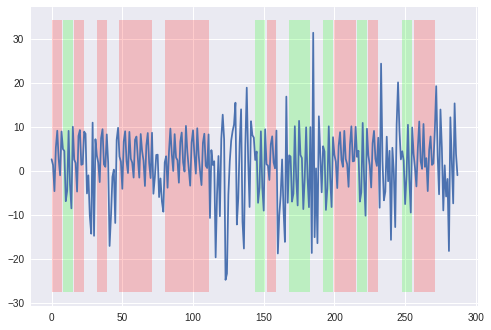

In [150]:
# the generated data object is of the form:
# [x=[sample_1, ..., sample_n], y=[motif_labels_1, ..., motif_labels_n]]
# the shaded areas correspond to proper motif locations
dgm.plot_regions(mmm_data[0][0], mmm_data[1][0])

In [195]:
cmmm_sim = dgm.FixedLengthContextWindow(num_motifs=num_motifs, 
                                        context_len=mpc, w=motif_length, 
                                        background_ratio=background_ratio)
cmmm_data = cmmm_sim.create_dataset(n_data=num_data)

100%|██████████| 10/10 [00:00<00:00, 37.75it/s]


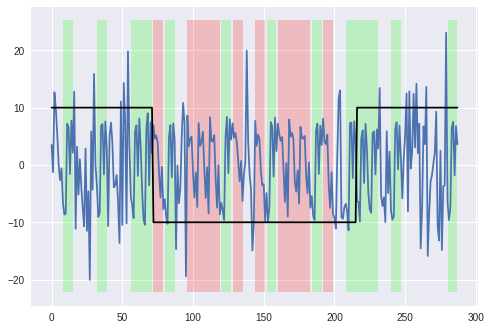

In [196]:
dgm.plot_regions(cmmm_data[0][0], cmmm_data[1][0][0])
# the black line indicates the (binary) context under which the data is generated
plt.plot(np.array(cmmm_data[1][0][1])*20-10, color='k')

### Independent Context Inference
We begin by performing independent context inference. For this problem, we use the ground truth motifs. In real practice, the motifs would be discovered in using any desired motif discovery technique.

In [214]:
# get the ground truth motifs
cmmm_motifs = [[cmmm_data[1][i][0][j] 
                for j in range(0, len(cmmm_data[0][0]), motif_length)] 
                   for i in range(len(cmmm_data[1]))]


In [218]:
# Finds the context
pcont = dgm.make_protocontext_vectors(cmmm_motifs, num_motifs+1, mpc)
contexts = dgm.cluster_protocontext(pcont, num_cont)

In [219]:
cmmm_cont = dgm.contextualize_data(contexts, mpc, cmmm_motifs)
cmmm_dummy = dgm.dummy_contextualize(cmmm_motifs, mpc, num_cont)

In [220]:
test = [cmmm_cont[0][i][1] for i in range(len(cmmm_cont[0]))]
test_expand = np.array([test[i] for i in range(len(test)) for j in range(motif_length)])

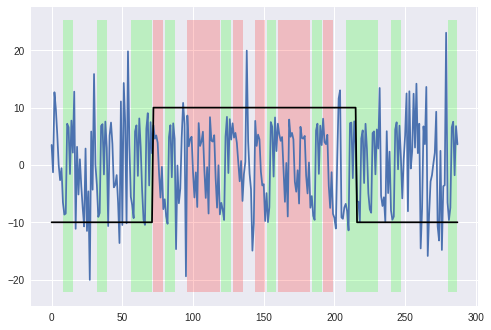

In [221]:
# we see that we've recovered the context quite well, though the label may be flipped
dgm.plot_regions(cmmm_data[0][0], cmmm_data[1][0][0])
plt.plot(test_expand*20-10, color='k')

### Joint Context Inference
While independent inference may work well given certain situations (like our simulation), we demonstrated in our paper that there can be an advantage to jointly discovering context and motifs. We accomplish this using a sampling approach described in the paper. The model used for sampling is given below.

In [ ]:
import pymc3 as pm
import theano
import theano.tensor as tt

In [ ]:
# the working CMMM model
# insert parameters and dataset here
num_motifs = None 
motif_length = None
num_cont = None

prop_std = None  # std for non-background motif 
c_per_x = None  # number of context windows per signal
m_per_c = None  # number of motifs per context window
dataset = None 
num_data = None  # amount of data to use  
with pm.Model() as cmmm:
    # context mixing
    alpha = pm.Dirichlet('alpha', a=np.ones(num_cont))
    
    alpha_min_potential = pm.Potential('alpha_min_potential', tt.switch(tt.min(alpha) < .3, -np.inf, 0))

    alpha_order_potential = {}
    for i in range(num_cont-1):
        alpha_order_potential[i] = pm.Potential('alpha_order_potential_%i'%i,
                                         tt.switch(alpha[i] > alpha[i+1], -np.inf, 0))
    # per-context motif mixing
    gamma = pm.Dirichlet('gamma', a=np.ones(num_motifs), shape=(num_cont, num_motifs))
    
    # build the motif parameters
    theta_mu = pm.Normal('theta_mu', 
                         mu=np.full(motif_length, 0), 
                         sd=np.full(motif_length, 3), 
                         shape=(num_motifs, motif_length))
    
    theta_sd = pm.Deterministic('theta_sd', 
                                 pm.math.switch(np.arange(num_motifs) >= num_motifs-1, 
                                                prop_std, 
                                                prop_std))
    
    theta_sd_reshape = theta_sd.reshape((num_motifs,1))
    theta_sd_long = tt.extra_ops.repeat(theta_sd_reshape, motif_length, 1)
    
    # contexts
    cntx = pm.Categorical('cntx',
                           p=alpha,
                           shape=(len(dataset[0:num_data]), c_per_x))
    
    # broaden to make one per motif
    # add dimension
    cntx_dplus = cntx.reshape((len(dataset[0:num_data]), c_per_x, 1))
    # tile along that dimension
    cntx_tile = tt.extra_ops.repeat(cntx_dplus, m_per_c, 2)
    # remove dimension
    long_cntx = cntx_tile.reshape((len(dataset[0:num_data]), c_per_x*m_per_c))
    
    # pick motif for each time
    motifs = {}
    x = {}
    for i in range(num_data):
        motifs[i] = pm.Categorical('motifs_%i' % i, p=gamma[long_cntx][i], shape=c_per_x*m_per_c)
        x[i] = pm.Normal('x_%i' % i, 
                  mu=theta_mu[motifs[i]], 
                  sd=theta_sd_long[motifs[i]], 
                  shape=(c_per_x*m_per_c, motif_length),
                  observed=dataset[i])